In [1]:
import os
import cv2
import pickle
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import keras
import tensorflow as tf

from tensorflow.keras import models,layers
from keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, r2_score

In [2]:
import os
import random
import shutil

def split_dataset(input_folder, output_folder, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1, seed=42):
    # Create output folders if they don't exist
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    val_folder = os.path.join(output_folder, 'validation')
    for folder in [train_folder, test_folder, val_folder]:
        os.makedirs(folder, exist_ok=True)

    # List all files in the input folder
    files = os.listdir(input_folder)
    random.seed(seed)
    random.shuffle(files)

    # Calculate the number of files for each split
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    num_test = int(num_files * test_ratio)
    num_val = num_files - num_train - num_test

    # Copy files to respective folders
    for i, file in enumerate(files):
        src = os.path.join(input_folder, file)
        if i < num_train:
            dst = os.path.join(train_folder, file)
        elif i < num_train + num_test:
            dst = os.path.join(test_folder, file)
        else:
            dst = os.path.join(val_folder, file)
        shutil.copy(src, dst)

# Example usage:
input_folder = r"C:\Users\Aman Yunus Badure\Desktop\Effect of Pesticides\RawData\split_8"
output_folder = r"C:\Users\Aman Yunus Badure\Desktop\Effect of Pesticides\Datasets\Dataset_8"
split_dataset(input_folder, output_folder)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Aman Yunus Badure\\Desktop\\Effect of Pesticides\\RawData\\split_8'

In [ ]:
train_path=r"C:\Users\Aman Yunus Badure\Desktop\Effect of Pesticides\Datasets\Dataset_1-2\train"
test_path=r"C:\Users\Aman Yunus Badure\Desktop\Effect of Pesticides\Datasets\Dataset_1-2\test"
val_path=r"C:\Users\Aman Yunus Badure\Desktop\Effect of Pesticides\Datasets\Dataset_1-2\validation"

In [3]:
def imagearray (path,size):
    rgb_images = []
    ndvi_values = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load RGB image
            try:
                # Load RGB image
                rgb_image = cv2.imread(os.path.join(path, filename))
                 # Calculate NDVI
               
                rgb_image = cv2.resize(rgb_image, size)
                ndvi = calculate_ndvi(rgb_image)
                print(ndvi)
                rgb_images.append(rgb_image)
                ndvi_values.append(ndvi)    
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    return rgb_images, ndvi_values


In [4]:
def calculate_ndvi(rgb_image):
    # Split RGB image into separate channels
    red = rgb_image[:, :, 0].astype(np.float32)
    green = rgb_image[:, :, 1].astype(np.float32)
    
    # Calculate synthetic NIR band (approximation)
    nir = (red + green) / 2.0
    
    # Normalize bands to range [0, 1]
    red /= 255.0
    nir /= 255.0
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red + 1e-8)  # Add small epsilon to avoid division by zero
    
    return ndvi


In [5]:
size = (224,224)

X_train, y_train = imagearray(train_path, size)
X_test,y_test = imagearray(test_path, size)
X_val,y_val = imagearray(val_path, size)

[[0.06187048 0.06222862 0.06158357 ... 0.17460318 0.22222221 0.23076922]
 [0.06151642 0.06017191 0.06295751 ... 0.18110237 0.23076922 0.23999996]
 [0.05785124 0.05686544 0.06051873 ... 0.16546763 0.23999996 0.26086953]
 ...
 [0.27272725 0.27272725 0.31428567 ... 0.14666665 0.14093958 0.14666665]
 [0.36507934 0.38983047 0.41818178 ... 0.14285713 0.14666665 0.14666665]
 [0.38983047 0.38983047 0.41818178 ... 0.14285713 0.14666665 0.14666665]]
[[0.08951406 0.08951406 0.08542713 ... 0.52941155 0.52941155 0.52941155]
 [0.09641873 0.09536784 0.08571427 ... 0.52941155 0.52941155 0.52941155]
 [0.14049588 0.13385828 0.10280372 ... 0.7142855  0.7142855  0.7142855 ]
 ...
 [0.3599999  0.3599999  0.3599999  ... 0.14049587 0.12871286 0.12832928]
 [0.31034476 0.31034476 0.31034476 ... 0.11208791 0.10472279 0.1030303 ]
 [0.31034476 0.31034476 0.31034476 ... 0.10548526 0.10059171 0.09902912]]
[[0.12698415 0.11969114 0.12977101 ... 0.04325699 0.04291285 0.04313723]
 [0.12500001 0.11787075 0.12840469 ... 

In [ ]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [93]:
print("Training data shapes:", X_train.shape, y_train.shape)
print("Testing data shapes:", X_test.shape, y_test.shape)
print("Validation data shapes:", X_val.shape, y_val.shape)

Training data shapes: (548, 224, 224, 3) (548, 224, 224)
Testing data shapes: (156, 224, 224, 3) (156, 224, 224)
Validation data shapes: (79, 224, 224, 3) (79, 224, 224)


In [44]:
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

In [25]:
# Constants
img_width, img_height = 224, 224
image_width, image_height = 224, 224
num_classes = 3  # Background, Other Vegetation, Wheat Heads

In [26]:
"""ndvi_input = Input(shape=(image_height, image_width, 3))
ndvi_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(ndvi_input)
# Add more convolutional layers as needed

# Add object localization layers on top of the base model
object_localization_layers = Conv2D(64, kernel_size=(3, 3), activation='relu')(base_model.output)
# Add more convolutional layers as needed

# Combine features from both paths
combined_features = concatenate([object_localization_layers, ndvi_conv1])

# Add additional layers for regression or classification
flatten = Flatten()(combined_features)
dense1 = Dense(128, activation='relu')(flatten)
output = Dense(num_classes, activation='softmax')(dense1)  # Adjust output size based on your task

# Create the final model
model = Model(inputs=[base_model.input, ndvi_input], outputs=output)"""

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 5, 5, 64), (None, 222, 222, 32)]

In [29]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze convolutional layers in the base model
for layer in base_model.layers:
    layer.trainable = False











In [12]:
# Add custom top layers for wheat head detection
#object_localization_layers = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Object_localization_layer')(base_model.output)
x = base_model.output
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Object_localization_layer')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Model for wheat head detection
detection_model = Model(inputs=base_model.input, outputs=predictions)
detection_input = detection_model.input

In [30]:
# Input layer for NDVI calculation
ndvi_input = Input(shape=(img_width, img_height, 3), name='ndvi_input')
ndvi_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu',name='ndvi_conv' )(ndvi_input)

# Calculate NDVI
red_band = ndvi_input[:, :, :, 0]  # Assuming red band is the first channel
green_band = ndvi_input[:, :, :, 1]  # Assuming NIR band is the fourth channel

# Calculate synthetic NIR band (approximation)
nir_band = (red_band + green_band) / 2.0
# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)  # Add small epsilon to avoid division by zero

In [31]:
"""# Combine NDVI with wheat head detection model
combined_model_output = concatenate([detection_model.output, ndvi])

# Add additional layers for final prediction
x = Dense(512, activation='relu')(combined_model_output)
predictions = Dense(num_classes, activation='softmax')(x)"""


'''x = Dense(512, activation='relu')(detection_model.output)
dense1 = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(dense1)'''
x = Dense(512, activation='relu')(ndvi)
dense1 = Dense(128, activation='relu')(x)
output_ndvi = Dense(224, activation=None)(dense1) 

In [33]:
# Combined model
combined_model = Model(inputs= ndvi_input, outputs=output_ndvi)

combined_model.summary()
# Compile the combined model
combined_model.compile(optimizer='adam', loss='mse')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ndvi_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 224, 224)             0         ['ndvi_input[0][0]']          
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_3  (None, 224, 224)             0         ['ndvi_input[0][0]']          
  (SlicingOpLambda)                                                                               
                                                                                            

In [68]:
"""
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pretrained layers
for layer in vgg19.layers:
    layer.trainable = False

# Create input layer for NDVI calculation
ndvi_input = Input(shape=(224, 224, 3), name='ndvi_input')

red_band = ndvi_input[:, :, :, 0]  # Assuming red band is the first channel
green_band = ndvi_input[:, :, :, 1]  # Assuming NIR band is the fourth channel

# Calculate synthetic NIR band (approximation)
nir_band = (red_band + green_band) / 2.0
# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)  # Add small epsilon to avoid division by zero


# Pass NDVI through additional Conv2D layers
ndvi = tf.expand_dims(ndvi, axis=-1)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(ndvi)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x_pooled = GlobalAveragePooling2D()(x)

# Add VGG19 base
vgg19_output = vgg19(ndvi_input)

# Flatten VGG19 output
vgg19_output_flatten = Flatten()(vgg19_output)
vgg_output_reduced = Dense(64, activation='relu')(vgg19_output_flatten)


# Concatenate Conv2D output and VGG19 output
# Get the number of features for x
num_filters_x = x_pooled.shape[-1]

# Get the number of features for vgg19_output_flatten
num_features_vgg19 = vgg_output_reduced.shape[-1]
print("x:", x_pooled.shape)
print("vgg:",vgg_output_reduced.shape)
# Ensure the number of features is the same
assert num_filters_x == num_features_vgg19, "Number of features for x and vgg19_output_flatten must match for concatenation"

# Concatenate Conv2D output and VGG19 output
concatenated_output = tf.keras.layers.Concatenate()([x_pooled, vgg_output_reduced])

# Add fully connected layers
x = Dense(512, activation='relu')(concatenated_output)
x = Dense(128, activation='relu')(x)

print("Dens:   ",dense1.shape)


# Output layer
output_ndvi = Dense(224, activation=None)(x)


# Combined model
model = Model(inputs=ndvi_input, outputs=output_ndvi)


# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()"""

x: (None, 64)
vgg: (None, 64)
Dens:    (None, 224, 128)
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ndvi_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_6  (None, 224, 224)             0         ['ndvi_input[0][0]']          
 0 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_6  (None, 224, 224)             0         ['ndvi_input[0][0]']          
 1 (SlicingOpLambda)                                                                              
                                   

In [9]:
# Load VGG19 model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pretrained layers
for layer in vgg19.layers:
    layer.trainable = False

# Input layer for NDVI calculation
ndvi_input = Input(shape=(224, 224, 3), name='ndvi_input')

# NDVI calculation
red_band = ndvi_input[:, :, :, 0]  
green_band = ndvi_input[:, :, :, 1]  

nir_band = (red_band + green_band) / 2.0
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)  

ndvi = tf.expand_dims(ndvi, axis=-1)
# Convolutional layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(ndvi)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)

# VGG19 base
vgg19_output = vgg19(ndvi_input)

# Flatten VGG19 output
vgg19_output = Flatten()(vgg19_output)

# Concatenate Conv2D output and VGG19 output
concatenated_output = tf.keras.layers.Concatenate()([x, vgg19_output])




# Add fully connected layers
x = Dense(512, activation='relu')(concatenated_output)
x = Dense(128, activation='relu')(x)

output_ndvi = Dense(224*224, activation=None)(x)  # Flattened output

# Reshape using Lambda layer
output_ndvi = Lambda(lambda x: tf.reshape(x, (-1, 224, 224)))(output_ndvi)

# Combined model
model = Model(inputs=ndvi_input, outputs=output_ndvi)

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ndvi_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_6  (None, 224, 224)             0         ['ndvi_input[0][0]']          
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_7  (None, 224, 224)             0         ['ndvi_input[0][0]']          
  (SlicingOpLambda)                                                                               
                                                                                            

In [34]:
"""model = models.Sequential([
    # Add convolutional and pooling layers as needed
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Add more layers as needed
    
    # Output layer with appropriate activation function
    layers.Conv2D(1, (1, 1), activation='sigmoid')  # Output layer with single channel for NDVI prediction
])"""

In [35]:
"""model.compile(optimizer='adam', loss='mse')
model.summary()"""

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 54, 54, 1)         65        
                                                                 
Total params: 19457 (76.00 KB)
Trainable params: 19457

In [47]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)

In [27]:
history = combined_model.fit([X_train,X_train], y_train, validation_data = ([X_val,X_val], y_val), epochs = 100, callbacks=[early_stop], batch_size = 8,
                    shuffle=True)

Epoch 1/100
64/64 [==============================] - 2s 36ms/step - loss: 0.0529 - accuracy: 0.0045 - val_loss: 0.0335 - val_accuracy: 0.0045
Epoch 2/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0295 - accuracy: 0.0050 - val_loss: 0.0255 - val_accuracy: 0.0049
Epoch 3/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0243 - accuracy: 0.0053 - val_loss: 0.0229 - val_accuracy: 0.0052
Epoch 4/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0226 - accuracy: 0.0056 - val_loss: 0.0219 - val_accuracy: 0.0050
Epoch 5/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0218 - accuracy: 0.0060 - val_loss: 0.0212 - val_accuracy: 0.0059
Epoch 6/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0212 - accuracy: 0.0065 - val_loss: 0.0207 - val_accuracy: 0.0072
Epoch 7/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0208 - accuracy: 0.0075 - val_loss: 0.0205 - val_accuracy: 0.0078
Epoch 

In [72]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, callbacks=[early_stop], batch_size = 8,
                    shuffle=True)

Epoch 1/25
64/64 [==============================] - 118s 2s/step - loss: 0.0240 - val_loss: 0.0236
Epoch 2/25
64/64 [==============================] - 114s 2s/step - loss: 0.0222 - val_loss: 0.0219
Epoch 3/25
64/64 [==============================] - 114s 2s/step - loss: 0.0218 - val_loss: 0.0224
Epoch 4/25
64/64 [==============================] - 115s 2s/step - loss: 0.0215 - val_loss: 0.0216
Epoch 5/25
64/64 [==============================] - 112s 2s/step - loss: 0.0213 - val_loss: 0.0219
Epoch 6/25
64/64 [==============================] - 113s 2s/step - loss: 0.0215 - val_loss: 0.0220
Epoch 7/25
64/64 [==============================] - 112s 2s/step - loss: 0.0217 - val_loss: 0.0218
Epoch 8/25
64/64 [==============================] - 112s 2s/step - loss: 0.0215 - val_loss: 0.0216
Epoch 9/25
64/64 [==============================] - 112s 2s/step - loss: 0.0211 - val_loss: 0.0215
Epoch 10/25
64/64 [==============================] - 111s 2s/step - loss: 0.0209 - val_loss: 0.0214
Epoch 11/

In [77]:
predicted_ndvi = np.squeeze(model.predict(X_test))
true_ndvi = y_test

rmse = np.sqrt(model.evaluate(X_test, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

true_ndvi_flat = true_ndvi.flatten()
predicted_ndvi_flat = predicted_ndvi.flatten()

# Calculate R^2 score
r2 = r2_score(true_ndvi_flat, predicted_ndvi_flat)
print("Test R^2 Score: {:.5f}".format(r2))

5/5 [==============================] - 18s 4s/step
     Test RMSE: 0.00000
Test R^2 Score: 0.28079


In [78]:
model.save('NDVI_prediction_CNN_V1.h5')

C:\Users\Aman Yunus Badure\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
loaded_model = tf.keras.models.load_model('NDVI_prediction_CNN.h5')


In [3]:
loaded_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ndvi_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_6  (None, 224, 224)             0         ['ndvi_input[0][0]']          
 2 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_6  (None, 224, 224)             0         ['ndvi_input[0][0]']          
 3 (SlicingOpLambda)                                                                              
                                                                                           

In [46]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)
history = loaded_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, callbacks=[early_stop], batch_size = 16,
                    shuffle=True)

Epoch 1/25
35/35 [==============================] - 124s 3s/step - loss: 0.0215 - val_loss: 0.0225
Epoch 2/25
35/35 [==============================] - 112s 3s/step - loss: 0.0212 - val_loss: 0.0222
Epoch 3/25
35/35 [==============================] - 110s 3s/step - loss: 0.0211 - val_loss: 0.0223
Epoch 4/25
35/35 [==============================] - 111s 3s/step - loss: 0.0211 - val_loss: 0.0223
Epoch 5/25
35/35 [==============================] - 112s 3s/step - loss: 0.0210 - val_loss: 0.0222
Epoch 6/25
35/35 [==============================] - 107s 3s/step - loss: 0.0210 - val_loss: 0.0222
Epoch 7/25
35/35 [==============================] - 109s 3s/step - loss: 0.0209 - val_loss: 0.0225
Epoch 8/25
35/35 [==============================] - 107s 3s/step - loss: 0.0209 - val_loss: 0.0223
Epoch 9/25
35/35 [==============================] - 108s 3s/step - loss: 0.0208 - val_loss: 0.0222
Epoch 10/25
35/35 [==============================] - 111s 3s/step - loss: 0.0208 - val_loss: 0.0223
Epoch 10:

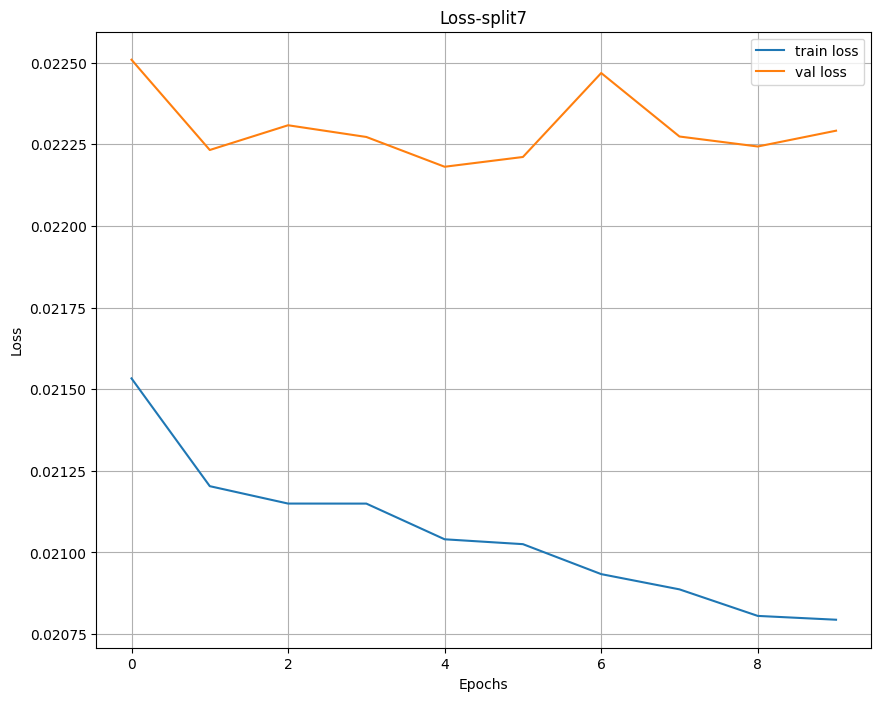

In [49]:


# Plot the graph
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss-split7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_plot_split7.png')  # Save the graph as a PNG file
plt.show()


In [25]:
loaded_model.evaluate(X_test, y_test, batch_size=8)


3/3 [==============================] - 3s 878ms/step - loss: 0.0186


0.018645349889993668

In [26]:
predicted_ndvi = np.squeeze(loaded_model.predict(X_test))
true_ndvi = y_test

rmse = np.sqrt(loaded_model.evaluate(X_test, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

true_ndvi_flat = true_ndvi.flatten()
predicted_ndvi_flat = predicted_ndvi.flatten()

# Calculate R^2 score
r2 = r2_score(true_ndvi_flat, predicted_ndvi_flat)
print("Test R^2 Score: {:.5f}".format(r2))

1/1 [==============================] - 3s 3s/step
     Test RMSE: 0.00000
Test R^2 Score: 0.31108


In [48]:
loaded_model.save('NDVI_prediction_CNN.h5')

C:\Users\Aman Yunus Badure\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


   Split    Loss  RMSE  R^2 Score
0      1  0.0227   0.0    0.28079
1      2  0.0260   0.0    0.38432
2      3  0.0202   0.0    0.35024
3      4  0.0209   0.0    0.36598
4      5  0.0245   0.0    0.38836
5      6  0.0235   0.0    0.35256
6      7  0.0225   0.0    0.37586
7      8  0.0246   0.0    0.32477
8      9  0.0235   0.0    0.36231
9     10  0.0186   0.0    0.31108


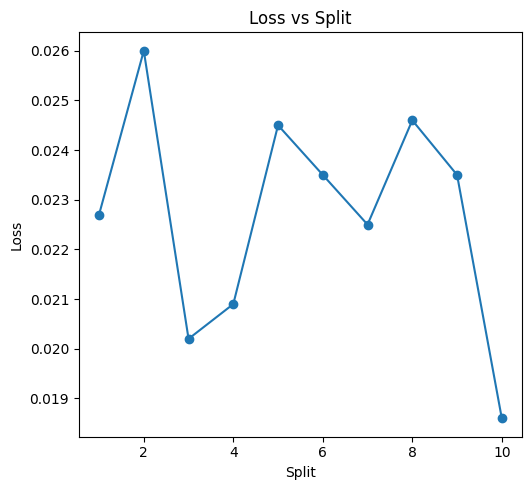

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Split': list(range(1, 11)),
    'Loss': [0.0227, 0.0260, 0.0202, 0.0209, 0.0245, 0.0235, 0.0225, 0.0246,0.0235,0.0186],
    'RMSE': [0.0] * 10,  # Assuming Test RMSE is consistently 0
    'R^2 Score': [0.28079, 0.38432, 0.35024, 0.36598, 0.38836, 0.35256, 0.37586, 0.32477,0.36231,0.31108]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Printing the DataFrame
print(df)

# Plotting
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(df['Split'], df['Loss'], marker='o', linestyle='-')
plt.title('Loss vs Split')
plt.xlabel('Split')
plt.ylabel('Loss')
plt.savefig('LossvsSplits.png')
plt.tight_layout()
plt.show()







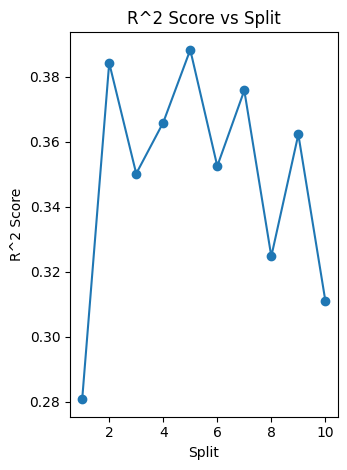

In [36]:
# Plot R^2 Score
plt.subplot(1, 2, 2)
plt.plot(df['Split'], df['R^2 Score'], marker='o', linestyle='-')
plt.title('R^2 Score vs Split')
plt.xlabel('Split')
plt.ylabel('R^2 Score')
plt.savefig('R^2vsSplits.png')
plt.tight_layout()
plt.show()

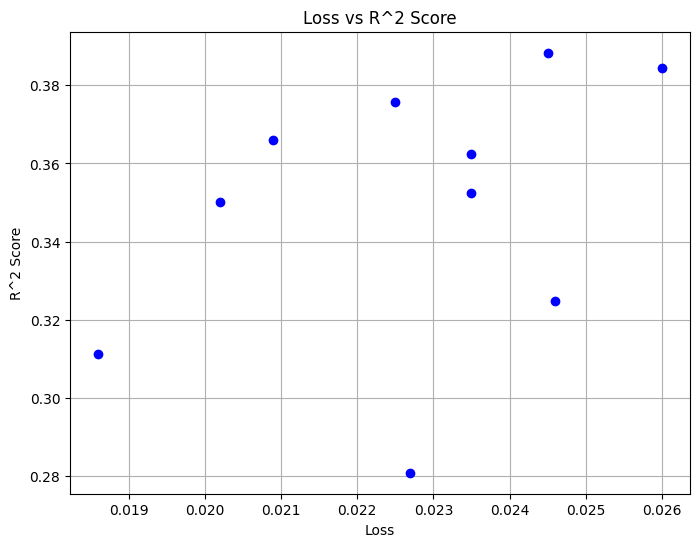

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(df['Loss'], df['R^2 Score'], marker='o', linestyle='', color='b')
plt.title('Loss vs R^2 Score')
plt.xlabel('Loss')
plt.ylabel('R^2 Score')
plt.savefig('R^2vsloss.png')
plt.grid(True)
plt.show()

In [38]:




# Save DataFrame to Excel
df.to_excel('evaluation_results.xlsx', index=False)

In [5]:
!pip install pydot
!pip install graphviz


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from keras.utils import plot_model
plot_model(loaded_model, to_file='model_architecture.png')

AttributeError: module 'pydot' has no attribute 'InvocationException'